In [2]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [3]:
def finDif(omega,f,n,bc):
    width = omega[-1] - omega[0]
    h = width/(n-1)

    # constructing A
    d0 = -30*ones((n,))  # main diagonal
    d1 = 16*ones((n-1,)) # first diagonal
    d2 = -ones((n-2,)) # second diagonal
    A = (
        diag(d0, 0) + 
        diag(d1, -1) + diag(d1, +1) + 
        diag(d2, -2) + diag(d2, +2)
    )
    A /= 12.*h*h
    A = -A

    # constructing b
    x = linspace(omega[0], omega[-1], n)
    b = f(x)
    
    # boundary conditions on first row
    A[0,:] = 0
    A[:,0] = 0
    A[0,0] = 1
    b[0] = bc[0]

    # boundary conditions on last row
    A[-1,:] = 0
    A[:,-1] = 0
    A[-1,-1] = 1
    b[-1] = bc[-1]

    return A, b

Call the function using:

In [102]:
omega = [0,pi]
f = lambda x : sin(x)
n = 100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

# exact solution for comparison
x = linspace(omega[0], omega[-1], n)
u_exact = sin(x)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [93]:
def LU(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        # check for null pivots
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
        
        # divide rows' first elements by pivot
        A[k+1:N,k] /= A[k,k]
        
        # update rows
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    # get L
    L=tril(A)
    # set L diagonal to ones
    for i in range(N):
        L[i,i]=1.0
    
    # get U
    U = triu(A)

    return L, U

L, U = LU(A)

In [94]:
def cholesky(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        # get diagonal element (pivot)
        A[k,k] = sqrt(A[k,k])
        
        # divide rows' first elements by pivot
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        # update rows and cols
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)
    return L, L.transpose()

HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [95]:
def L_solve(L,rhs):
    x = zeros_like(rhs)
    N = len(L)
    
    # forward substitution
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i]
        
    return x

In [96]:
def U_solve(U,rhs):
    x = zeros_like(rhs)
    N = len(U)
    
    # backward substitution
    x[-1] = rhs[-1]/L[-1,-1]
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] - dot(U[i, i+1:N], x[i+1:N]))/U[i,i]

    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

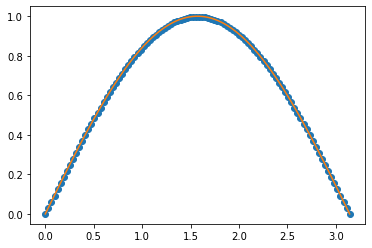

In [103]:
# using LU factorization
w_lu = L_solve(L, b)
u_lu = U_solve(U,w_lu)

# plot solution
_ = plot(x,u_lu,'o-')
_ = plot(x,u_exact)

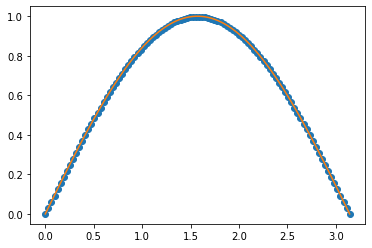

In [105]:
# using Cholesky factorization
w_ch = L_solve(HT,b)
u_ch = U_solve(H,w_ch)

# plot solution
_ = plot(x,u_ch,'o-')
_ = plot(x,u_exact)

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [99]:
def get_errors(omega, f, bc, points):
    errors = []
    for i in range(len(points)):
        n = points[i]
        # exact solution
        x = linspace(omega[0], omega[1], n)
        u_exact = x**4/12. - x**3/6. + x/12.

        # direct solution
        An, bn = finDif(omega, f, n, bc)
        Ln, Un = LU(An)
        wn = L_solve(Ln, bn)
        un = U_solve(Un, wn)

        # get error
        err = linalg.norm(u_exact - un, 2)
        errors.append(err)
    
    return errors    

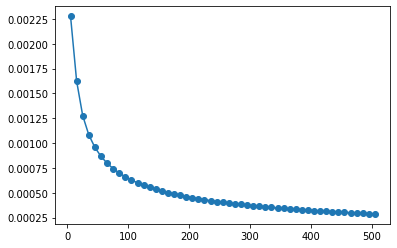

In [106]:
omega = [0,1]
bc = [0,0]
f = lambda x: x*(1-x)
points = list(range(5, 506, 10))

# plot
errors = get_errors(omega, f, bc, points)
_ = plot(points, errors, 'o-')

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [ ]:
def condNumb(A):
    pass #TODO
    return condNu

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

iterations = 50
tolerance = 7.022769695016658e-12


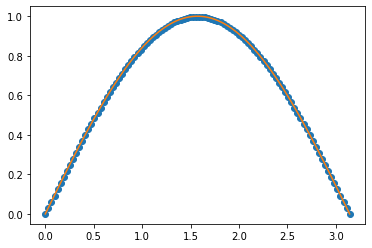

In [108]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
    N = len(A)
    x = zeros_like(b)
    r = b - dot(A,x)
    rho_old = 1.
    p_old = zeros_like(b)
    tol = eps + 1.0
    it = 0
    while (it < nmax and tol > eps):
        it += 1
        z = linalg.solve(P,r)
        rho = dot(r,z)
        if (it > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        q = dot(A,p)
        alpha = rho/dot(p,q)
        
        x += p*alpha
        r -= q*alpha
        p_old = p
        rho_old = rho
        tol = linalg.norm(r,2)

    print("iterations =",it)
    print("tolerance =", tol)
    return x

u_cg = conjugate_gradient(A, b, identity(len(A)))
_ = plot(x, u_cg, 'o-')
_ = plot(x, u_exact)

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [ ]:
#TODO

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [ ]:
#TODO

Compute the inverse of the matrix A exploiting the derived LU factorization

In [109]:
# loop and compute each column of inverse matrix
def inverse_from_LU(L,U):
    N = len(L)
    inv = zeros((N,N))
    for k in range(N):
        ek = zeros((N,))
        ek[k] = 1
        wk = L_solve(L, ek)
        xk = U_solve(U, wk)
        inv[:,k] = xk
    
    return inv

invA = inverse_from_LU(L,U)
# inVera = linalg.inv(A)
# print(invA - inVera)

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [110]:
# define Cauchy problem
t0 = 0.0
tf = 2.0
y0 = 1.0

In [111]:
# solve nonlinear eq in BE
def newton(f, f_prime, x0, eps=1e-10, n_max=1000):
    assert abs(f_prime(x0)) > 1e-16
    err = abs(f(x0))
    errors = [err]
    it = 0
    x = x0
    while (err > eps and it < n_max):
        # check divisor is not too small
        qk = f_prime(x)
        if abs(qk) < 1e-12:
            raise RuntimeError("f_prime(x) is close to zero")
        
        # get new value of x and error
        x_new = x - f(x)/qk 
        err = abs(f(x_new))
        
        # updtating 
        x = x_new
        it += 1

    return x

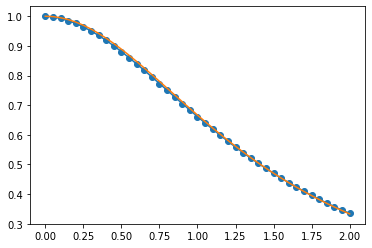

In [112]:
# BE method
def be(y0, t0, tf, h):
    t = arange(t0, tf+1e-10, h)
    sol = zeros_like(t)
    sol[0] = y0
    for i in range(1, len(sol)):
        g = lambda y: t[i]*h*y**2 + y - sol[i-1]
        g_prime = lambda y: 2*t[i]*h*y + 1
        sol[i] = newton(g, g_prime, sol[i-1])

    return sol, t

y, t = be(y0, t0, tf, 0.05)
y_exact = 1./(t*t/2. + 1./y0)

_ = plot(t, y, 'o-')
_ = plot(t, y_exact)